https://drive.google.com/open?id=0B-zGzdkbH440aDh1ckN4SWJlQ2ozeGM2cTNWN0lEY2R6NVhN

In [7]:
import numpy as np
import pandas as pd
#import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor

In [8]:
from sklearn.model_selection import train_test_split, cross_validate, validation_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

In [33]:
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

expit  # sigmoid


from scipy import interp

class AverageROC(object):
    def __init__(self, fpr_grid):
        if isinstance(grid, int):
            self.fpr = np.linspace(0, 1, grid+1)
        else:
            self.fpr = grid    
        assert np.all((self.fpr >= 0) & (self.fpr <= 1)), "fpr grid must be between 0 and 1"
        self.l_tpr = []
            
    def align_roc(self, fpr, tpr):
        tpr_aligned = interp(fpr_aligned, fpr, tpr)
        tpr_aligned[0] = 0.
        return tpr_aligned
    
    def append(self, fpr, tpr):
        tpr_aligned = self.align_roc(fpr, tpr)
        self.l_tpr.append(tpr_aligned)
        
    def average_roc(self):
        return np.mean(self.l_tpr, axis=1)
    
    

def align_roc_curve(fpr, tpr, grid=100):
    """calculate ROC curve on a predefined grid by interpolating"""
    if isinstance(grid, int):
        fpr_aligned = np.linspace(0, 1, grid+1)
    else:
        fpr_aligned = grid    
    tpr_aligned = interp(fpr_aligned, fpr, tpr)
    tpr_aligned[0] = 0.
    return fpr_aligned, tpr_aligned

### Ia. ROC curve and AUC (practical)

1. Sample $X_1 \in R^{m_1×n}$
elementwise from standard normal distribution, e.g. use <code>np.random.randn(m1, n)</code>;
2. Sample true parameters' vector w elementwise from normal distribution with
standard deviation 0.1, e.g. <code>w = 0.1 * np.random.randn(n);</code>
3. For each object (both in training sample defined by $X_1$ and testing sample defined
by $X_2$) calculate the probability $p_j$ that object $x_j$ belongs to class 1 according to
logistic regression model, i.e. $p_j = \sigma(w^T x_j)$;
4. Sample the class label for each object (both in training sample defined by $X_1$ and
testing sample defined by $X_2$) from Bernoulli distribution with corresponding
probability of first class, i.e. $y_j \propto Be(p_j)$.

In [3]:
m1 = 1000
m2 = 10000
n  = 20

In [13]:
# sample data
X1 = np.random.randn(m1, n)
X2 = np.random.randn(m2, n)
# sample true parameters of underlying model from N(0, 0.1^2)
w  = 0.1 * np.random.randn(n)
# generate labels for training and testing
p1 = sigmoid(np.dot(X1, w))
p2 = sigmoid(np.dot(X2, w))
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

5. Split learning sample into 2 of size 800 and 200;
6. Train linear SVM with a grid of regularization strength $C$ values on the first one of size 800, calculate ROC-curve and check AUC of its predictions for the second subsample of size 200;
7. Repeat the split multiple times and plot the histogram of AUC distribution for the subsample of size 200 as well as the average ROC-curve;

In [383]:
ppe = ProcessPoolExecutor(max_workers=4)



def run_cross_validation((experiment, Cs)):
    X_train, X_validate, y_train, y_validate = train_test_split(X1, y1, train_size=800, random_state=experiment+1000)
    data = []
    for C in Cs:
        rec = {
            "experiment": random_state,
            "C"         : C,
        }
        clf.set_params(C=C)
        clf.fit(X_train, y_train)
        rec["coef"] = clf.coef_.flatten()
        for (prefix, X, y) in [("val", X_validate, y_validate), ("train", X_train, y_train)]: 
            y_score = clf.decision_function(X)
            y_predicted = clf.predict(X)
            fpr, tpr, thresholds = roc_curve(y, y_score)
            _, tpr_aligned = align_roc_curve(fpr, tpr, grid=fpr_aligned)

            rec["%s_auc" % prefix]      = auc(fpr, tpr)
            rec["%s_tpr" % prefix]      = tpr_aligned
            rec["%s_accuracy" % prefix] = accuracy_score(y, y_predicted)
            rec["%s_npos" % prefix] = (y_predicted > 0).sum()
        data.append(rec)
    return data

def run_experiments(clf, Cs, nexperiments=100):
    data = []
    fpr_aligned = np.linspace(0, 1, 101)

    data = ppe.map(run_cross_validation, [(i, Cs) for i in range(nexperiments)])
    data = [rec for x in data for rec in x]
    df = pd.DataFrame(data)
    return df



In [407]:
def plot_experiments_stats(df, Cs):
    f = plt.figure(figsize=(18,len(Cs) * 2))
    axs = f.subplots(len(Cs), 3, sharex='col', )
    for i, C in enumerate(Cs):
        df_C = df[(df["C"] - C).abs() < 1e-12]
        ax = axs[i, 0]
        for prefix in ["val", "train"]:
            m_tpr = np.vstack(df_C["%s_tpr" % prefix])
            roc_mean = m_tpr.mean(0)
            roc_std  = m_tpr.std(0)
            roc_upper = np.minimum(roc_mean + roc_std, 1.)
            roc_lower = np.maximum(roc_mean - roc_std, 0.)
            ax.plot(fpr_aligned, roc_mean)
            ax.fill_between(fpr_aligned, roc_lower, roc_upper, alpha=0.3)
        ax.plot(fpr_aligned, fpr_aligned, label='clf_random', color='black')
        ax.set_title("Avg ROC. C=%.e" % C)
        ax = axs[i, 1]
        sns.distplot(df_C["val_auc"], rug=True, kde=True, ax=ax)
        ax.axvline(x= df_C["val_auc"].mean(), ls='--')
        sns.distplot(df_C["train_auc"], rug=True, kde=True, ax=ax)
        ax.axvline(x= df_C["train_auc"].mean(), ls='--')
        ax.set_title("Hist(AUC). C=%.e" % C)
        ax = axs[i, 2]
        sns.distplot(df_C["val_accuracy"], rug=True, kde=True, ax=ax, )
        ax.axvline(x= df_C["val_accuracy"].mean(), ls='--')
        sns.distplot(df_C["train_accuracy"], rug=True, kde=True, ax=ax, )
        ax.axvline(x= df_C["train_accuracy"].mean(), ls='--')
        ax.set_title("Hist(Accuracy). C=%.e" % C)

    for ax in axs.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)
        ax.autoscale()
        ax.legend(loc="upper left")
    f.tight_layout()

def plot_cv(df, Cs):
    f = plt.figure(figsize=(18, 4))
    axs = f.subplots(1, 4, squeeze=False)

    def _plot(ax, field):
        means = np.array([df[df['C']==C][field].mean() for C in Cs])
        stds = np.array([df[df['C']==C][field].std() for C in Cs])
        xlabels = np.log10(Cs)
        ax.plot(xlabels, means, label=field)
        ax.fill_between(xlabels, means - stds, means + stds, alpha=0.3)

    _plot(axs[0, 0], "val_accuracy")
    _plot(axs[0, 0], "train_accuracy")
    axs[0,0].set_title("accuracy")
    _plot(axs[0, 1], "val_auc")
    _plot(axs[0, 1], "train_auc")
    axs[0,1].set_title("auc")
    _plot(axs[0, 2], "val_npos")
    _plot(axs[0, 2], "train_npos")
    axs[0,2].set_title("npos")
    ax = axs[0,3]
    ax.plot(np.log10(Cs), np.vstack(df.groupby('C')['coef'].apply(lambda x: np.vstack(x).mean(0)).values))
    axs[0,3].set_title("coef")
    for ax in axs.flatten():
        ax.legend(loc="upper center", fontsize="x-small")    

8. Select regularization strength $C^∗$ that delivers maximum average (or median) AUC on the subsample of size 200;
9. Check performance of SVM with selected $C = C^∗$ trained on the full learning sample on testing sample $(X_2, y_2)$ in terms of AUC and prediction accuracy. How far are these values from the AUC and prediction accuracy on learning sample? Do you think there is some systematic difference or is it explained just by noise?

__Answer__: The difference is explained by overfitting.
We can easily reject H0: no difference between score_train and score_val base on our experiments above. So this is a systematic effect.
The values I got for learn vs test is within 1 std of expected difference.

10. Train logistic regression model (sklearn.linear_model.LogisticRegression) with a grid of regularization strength $\tau$ values including 0 (C in that python class) both
for quadratic and $l_1$ penalties (penalty parameter for this python class) on the first subsample of size 800, calculate ROC-curve and check AUC of its predictions
for the second subsample of size 200;
11. Repeat the split multiple times and plot the histogram of AUC distribution for the subsample of size 200 as well as the average ROC-curve;
12. Select regularization strength $\tau^*$ that delivers maximum average (or median) AUC on the subsample of size 200. What optimal regulatization strength do you get? Why?

__Answer__: l2


13. Check performance of logistic regression with selected $\tau = \tau^*$ trained on the full learning sample on testing sample $(X_2, y_2)$ in terms of AUC and prediction
accuracy. How far are these values from the AUC and prediction accuracy on learning sample? Do you think there is some systematic dierence or is it explained just by noise?

__Answer__: Same answer as for 9

running experiments
CPU times: user 50.3 ms, sys: 10.2 ms, total: 60.5 ms
Wall time: 1.13 s
plotting stats
choosing C*
C
0.000001        0.500000
0.000010        0.500000
0.000100        0.500000
0.001000        0.500000
0.010000        0.500000
0.100000        0.611107
1.000000        0.614586
10.000000       0.613635
100.000000      0.613323
1000.000000     0.613373
10000.000000    0.613373
Name: val_auc, dtype: float64
C* = 1.0
[[-0.19908582  0.11689641 -0.22206967 -0.04299874  0.09057399 -0.2073323
   0.08389416  0.04231907  0.          0.02659044 -0.05639081 -0.07687555
   0.04937424 -0.12508471  0.03432284 -0.08137862  0.01367501 -0.21592434
  -0.23820818  0.1524709 ]]
                AUC       ACC
train      0.657016  0.610000
test       0.579876  0.560300
diff       0.077140  0.049700
E[diff]    0.043903  0.035163
std[diff]  0.041909  0.039231

H0: E[diff_accuracy] == 0:  Ttest_1sampResult(statistic=8.9629490279046902, pvalue=1.9945468611946672e-14)
H0: E[diff_auc] == 0     :  

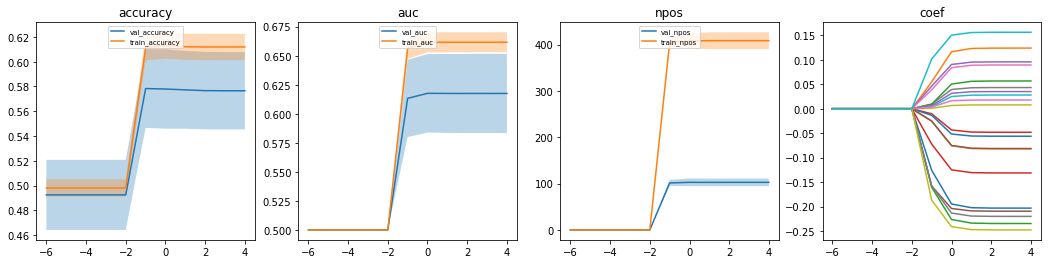

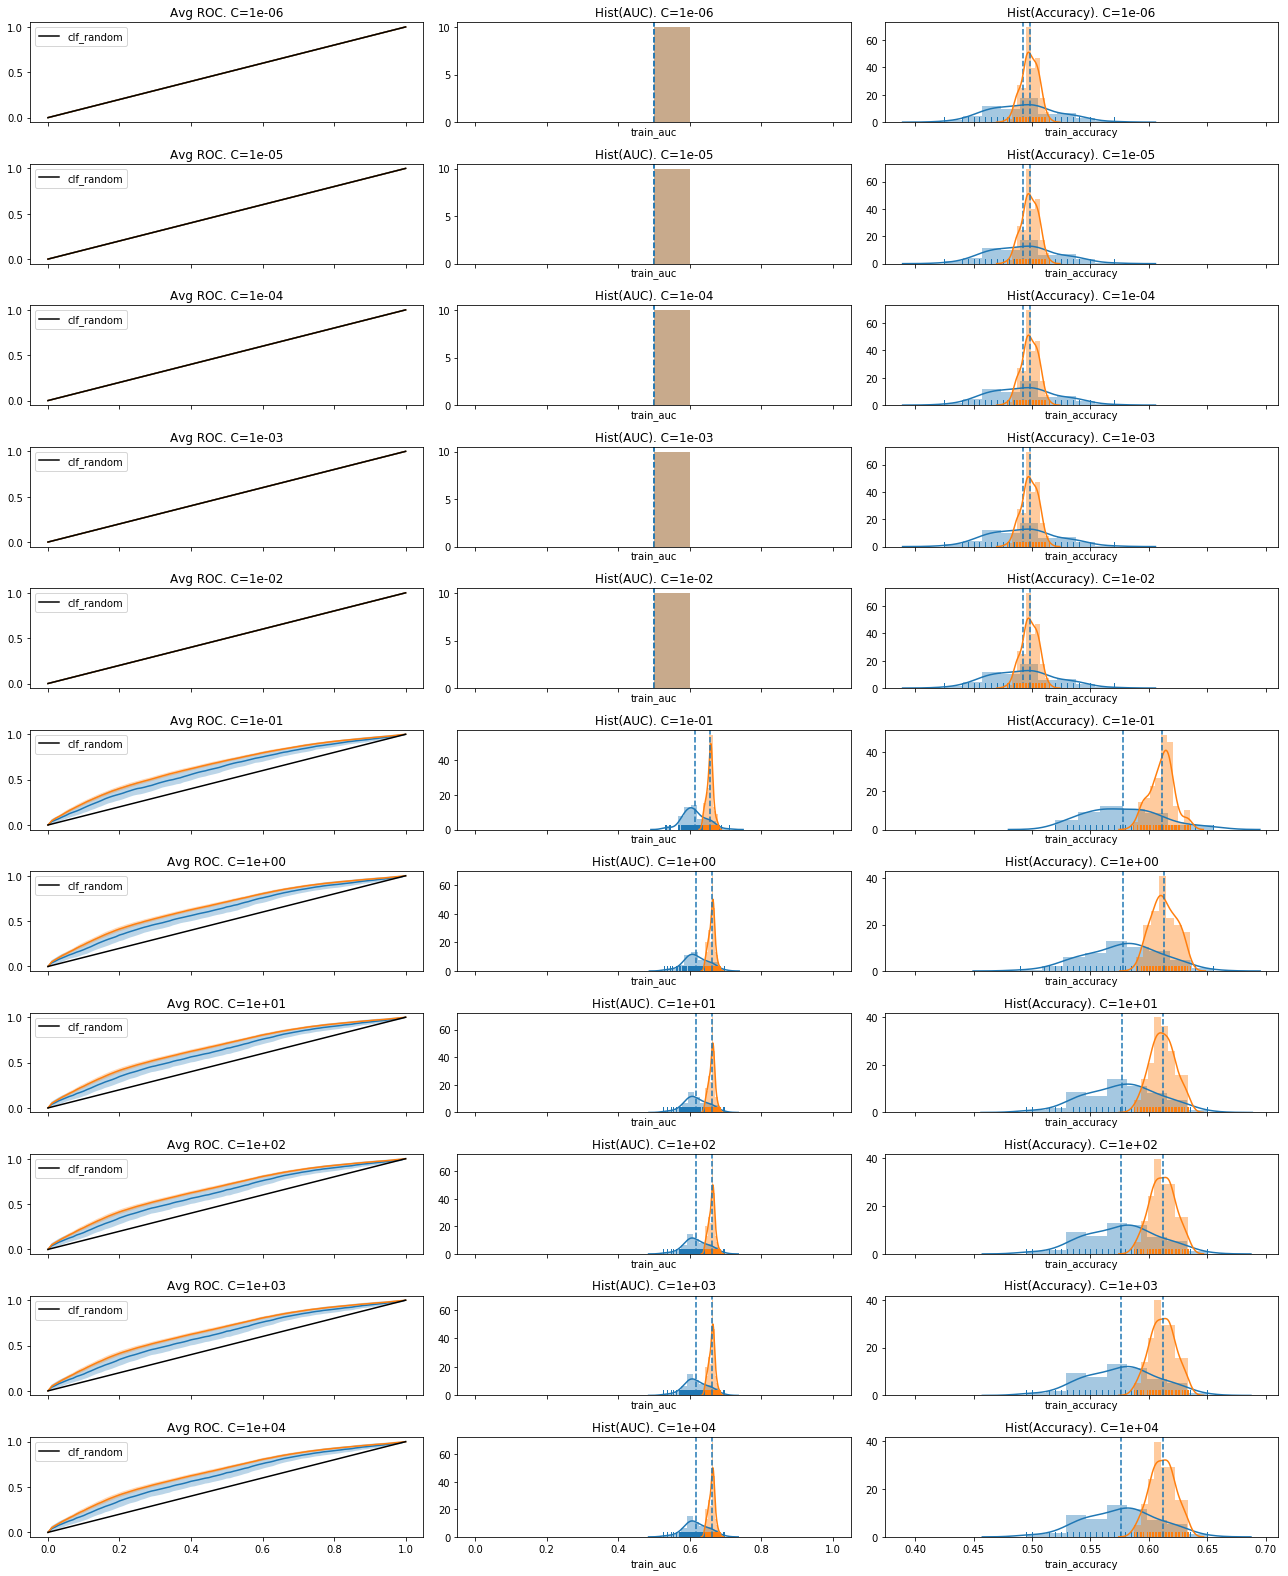

In [413]:
### CHANGE CLASSIFIER HERE ###

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

#clf = SVC(kernel='linear', max_iter=-1 )
#Cs = np.logspace(-6, 1, 8)

clf = LogisticRegression(C=1, penalty="l1")
Cs = np.logspace(-6, 4, 11)
########################################

print "running experiments"
%time df = run_experiments(clf, Cs, nexperiments=100)


print "plotting stats"  
plot_cv(df, Cs)
plot_experiments_stats(df, Cs)

print "choosing C*"
print df.groupby('C')["val_auc"].median()
C_ = df.groupby('C')["val_auc"].median().argmax()
print "C* =", C_

# override, because something seems wrong with too low values of C
if C_ < 1e-3:
    C_ = 1.
    print "overriding C* =", C_

    
clf.set_params(C=C_)
clf.fit(X1, y1)
print clf.coef_

y1_predicted = clf.predict(X1)
y1_score = clf.decision_function(X1)
train_auc = roc_auc_score(y1, y1_score)
train_accuracy = accuracy_score(y1, y1_predicted)

res = pd.DataFrame()
res.loc["train", "AUC"] = train_auc
res.loc["train", "ACC"] = train_accuracy

y2_predicted = clf.predict(X2)
y2_score = clf.decision_function(X2)
test_auc = roc_auc_score(y2, y2_score)
test_accuracy = accuracy_score(y2, y2_predicted)
res.loc["test", "AUC"] = test_auc
res.loc["test", "ACC"] = test_accuracy
res.loc["diff"] = res.loc["train"] - res.loc["test"]

_df = df[(df["C"] - C_).abs() < 1e-10]
_df.loc[:, "diff_accuracy"] = _df["train_accuracy"] - df["val_accuracy"]
_df.loc[:, "diff_auc"] = _df["train_auc"] - df["val_auc"]

res.loc["E[diff]", "AUC"] = (_df["diff_auc"]).mean()
res.loc["E[diff]", "ACC"] = (_df["diff_accuracy"]).mean()
res.loc["std[diff]", "AUC"] = (_df["diff_auc"]).std()
res.loc["std[diff]", "ACC"] = (_df["diff_accuracy"]).std()


print res
print

import scipy.stats
print "H0: E[diff_accuracy] == 0: ", scipy.stats.ttest_1samp(_df["diff_accuracy"], 0)
print "H0: E[diff_auc] == 0     : ", scipy.stats.ttest_1samp(_df["diff_auc"], 0)

(array([3., 2., 1., 2., 2., 2., 2., 2., 2., 2.]),
 array([0.03922077, 0.04141014, 0.0435995 , 0.04578886, 0.04797823,
        0.05016759, 0.05235695, 0.05454632, 0.05673568, 0.05892504,
        0.0611144 ]),
 <a list of 10 Patch objects>)

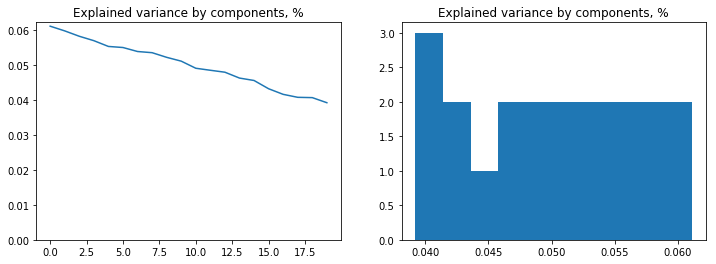

In [123]:
pca = PCA()
pca.fit(X1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1, 2, 1, title="Explained variance by components, %")
ax.plot(pca.explained_variance_ratio_)
ax.set_ylim(bottom=0)
ax = f.add_subplot(1, 2, 2, title="Explained variance by components, %")
ax.hist(pca.explained_variance_ratio_)
#sns.kdeplot(pca.explained_variance_ratio_, ax=ax, kernel='cos')



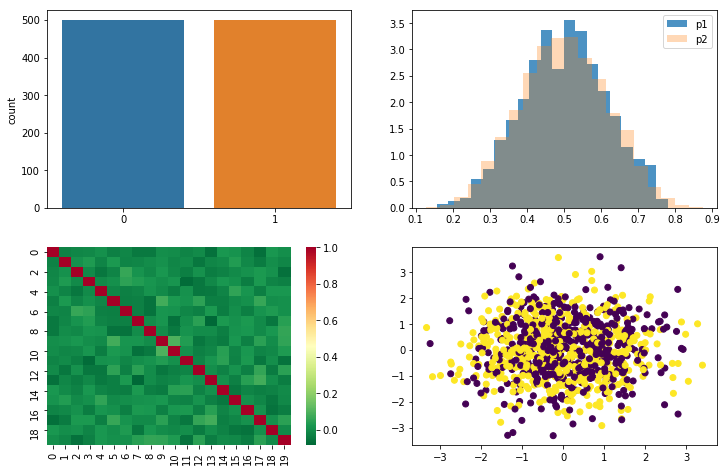

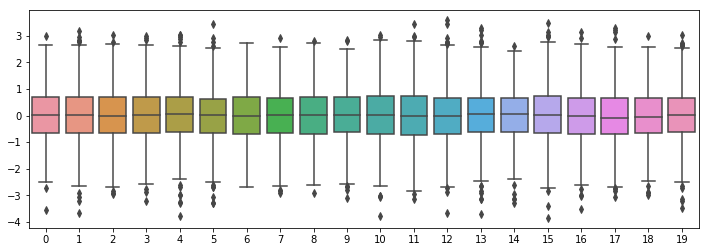

In [9]:
f = plt.figure(figsize=(12,8))
axs = f.subplots(2, 2)
sns.countplot(y1, ax=axs[0, 0])
#ax.hist()
#sns.kdeplot()
axs[0, 1].hist(p1, alpha=0.8, bins=20, label="p1", density=True)
axs[0, 1].hist(p2, alpha=0.3, bins=20, label="p2", density=True)
axs[0, 1].legend()
sns.heatmap(np.corrcoef(X1.T), cmap='RdYlGn_r', ax=axs[1,0])
_X = pca.transform(X1)[:, :2]
axs[1, 1].scatter(_X[:, 0], _X[:, 1], c=y1)
f = plt.figure(figsize=(12,4))
ax = f.add_subplot(1,1,1)
sns.boxplot(data=X1, )
#_ = ax.boxplot(X1)


In [157]:
clf.set_params(C=1e-5)

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [158]:
X_train, X_validate, y_train, y_validate_true = train_test_split(X1, y1, train_size=0.8)
clf.fit(X_train, y_train)
y_validate_score = clf.decision_function(X_validate)
y_validate_predicted = clf.predict(X_validate)


{'boxes': [<matplotlib.lines.Line2D at 0x186e8400>],
 'caps': [<matplotlib.lines.Line2D at 0x1d5e5550>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d5e5940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1d5e52b0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x186e8390>,
  <matplotlib.lines.Line2D at 0x1d5e5a90>]}

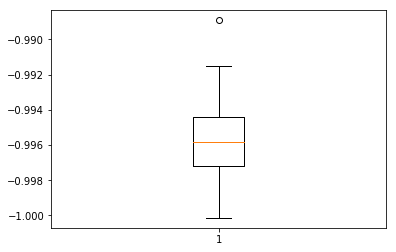

In [159]:
plt.boxplot(y_validate_score)

In [165]:
from scipy.stats import itemfreq
print Counter(y_validate_score > 0)
print itemfreq(y_validate_true)

print roc_auc_score(y_validate_true, y_validate_score)
print accuracy_score(y_validate_true, y_pred=y_validate_predicted)

Counter({False: 200})
[[  0  91]
 [  1 109]]
0.6051013206976509
0.455


In [168]:
109 / 200.

0.545

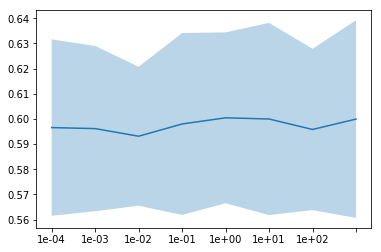

In [44]:
df_auc = pd.DataFrame(data, columns=['C', 'auc.mean', 'auc.std'])
f, ax = plt.subplots()
ax.plot(df_auc["auc.mean"])
ax.fill_between(np.arange(len(df_auc)), 
                 df_auc["auc.mean"] - df_auc["auc.std"], 
                 df_auc["auc.mean"] + df_auc["auc.std"],
                 alpha = 0.3,
                )
_ = ax.set_xticklabels(["%.e" % x for x in df_auc["C"]])

In [ ]:
plt.plot([0, 1], [0, 1], 'k--', lw=lw)


In [59]:
clf = LogisticRegression( C=1.)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 1b. ROC curve and AUC (semi-practical)

In [173]:
# sample data
X1 = np.random.randn(m1, n)
X2 = np.random.randn(m2, n)
# sample true parameters of underlying model from N(0, 0.1^2)
w  = 0.1 * np.random.randn(n)
# generate labels for training and testing
p1 = sigmoid(np.dot(X1, w))
p2 = sigmoid(np.dot(X2, w))
y1 = np.random.binomial(1, p1)
y2 = np.random.binomial(1, p2)

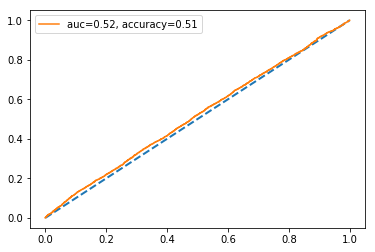

In [283]:
w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
prob_predicted = sigmoid(np.dot(X2, w0))
y_predicted = prob_predicted > 0.5
fpr, tpr, thresholds = roc_curve(y2, prob_predicted)

f = plt.figure(figsize=(6, 4))
ax = f.add_subplot(1,1,1)
ax.plot([0,1], lw=2, ls='--')
accuracy = accuracy_score(y2, y_predicted)
ax.plot(fpr, tpr, label="auc=%.2f, accuracy=%.2f" % (auc(fpr, tpr), accuracy))
ax.legend()


0.5003429628754963
0.027928477251715374


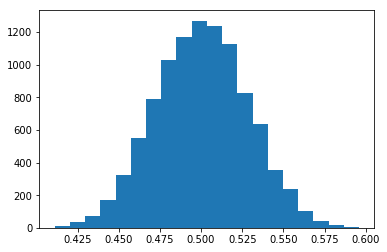

In [286]:
l_auc = []
for _ in range(10000):
    w0 = 0.1 * np.random.randn(n)     # noise estimate of w: p(w0|X, T) = p(w0) 
    prob_predicted = sigmoid(np.dot(X2, w0))
    l_auc.append(roc_auc_score(y2, prob_predicted))

plt.hist(l_auc, bins=20)
print np.mean(l_auc)
print np.std(l_auc)